In [1]:
import numpy as np
import pandas as pd
import openturns as ot
import otbenchmark as otb
from matplotlib import cm
from matplotlib import pyplot as plt
from bancs import *

In [2]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{bm}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [3]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
greys = mpl.colormaps['Greys_r']
faded_greys = ListedColormap(greys(np.linspace(0.4, 1, 128)))

## Four branch reliability problem

In [4]:
problem4B = otb.FourBranchSerialSystemReliability()
failure_event = problem4B.getEvent()
pf_ref = problem4B.getProbability()

## BANCS : Bernstein Adaptive Conditional Sampling

In [5]:
int(1 + np.floor(5000 ** (2 / (4 + 8))))

5

Quantiles = [ 1.43687941  0.17635559 -1.17165864]
Proba EBC = 2.17e-03
Relative error = 0.62%


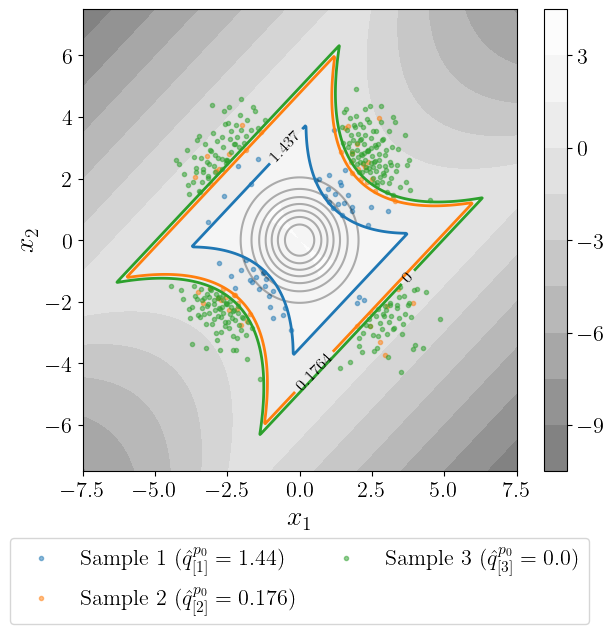

In [14]:
N = int(5e2)
bancs = BANCS(failure_event, N=N, M=6, p0=0.1)
quantiles = bancs.run()
pf = bancs.compute_pf()
print("Quantiles =", quantiles)
print("Proba EBC = {:.2e}".format(pf))
print("Relative error = {:.2%}".format(np.abs(pf - pf_ref) / pf_ref))
fig = bancs.draw_2D_BANCS(colorbar=faded_greys)
plt.savefig("figures/bancs_4branch.pdf", bbox_inches='tight')
plt.savefig("figures/bancs_4branch.jpg", bbox_inches='tight', dpi=300);

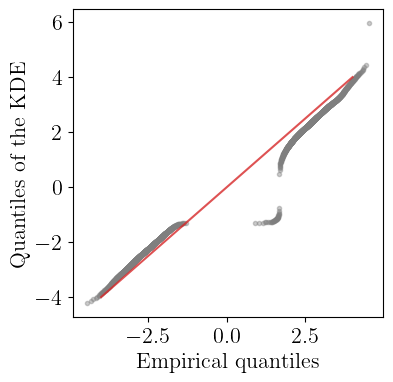

In [11]:
# Marginals goodness of fit
ss_index = 2
xi = 0
failed_sample = bancs.df[(bancs.df["Failed"]==1) & (bancs.df["Subset"]==ss_index)]["X"+str(xi)].values.reshape(-1, 1) 
empirical_dist = ot.UserDefined(failed_sample)
fitted_marginal = bancs.conditional_distributions[ss_index].getMarginal(xi)

empirical_levels = empirical_dist.computeCDF(failed_sample)
kde_quantiles = fitted_marginal.computeQuantile(np.array(empirical_levels).flatten())

plt.figure(figsize=(4, 4))
plt.scatter(failed_sample, kde_quantiles, marker='.', color="C7", alpha=0.4)
plt.plot([-4, 4], [-4, 4], color="C3", alpha=0.8)
plt.xlabel("Empirical quantiles")
plt.ylabel("Quantiles of the KDE")
plt.savefig("figures/qqplot_4branch.png", dpi=300, bbox_inches='tight');

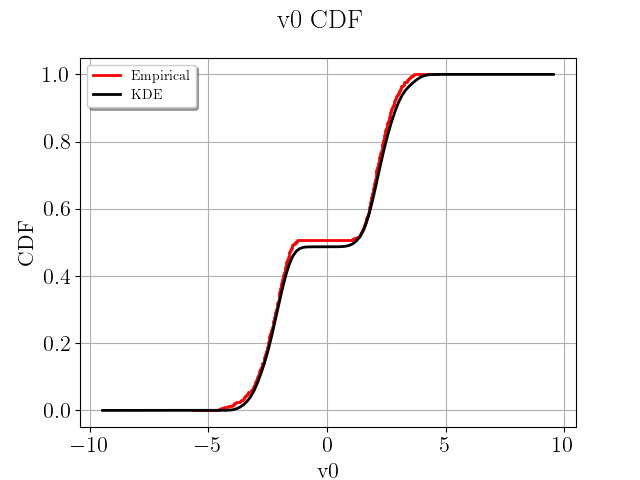

In [12]:
# Marginals goodness of fit
subset_idx = 2
xi = 0
sample = bancs.df[(bancs.df["Failed"]==1) & (bancs.df["Subset"]==subset_idx-1)]["X"+str(xi+1)].values.reshape(-1, 1) 
empirical = ot.UserDefined(sample)
fitted_marginal = bancs.conditional_distributions[subset_idx].getMarginal(xi)
graph = empirical.drawCDF()
graph.add(fitted_marginal.drawCDF())
graph.setLegends(['Empirical', 'KDE', 'KDE mixture'])
graph.setColors(['red','black', 'blue', 'green'])
graph

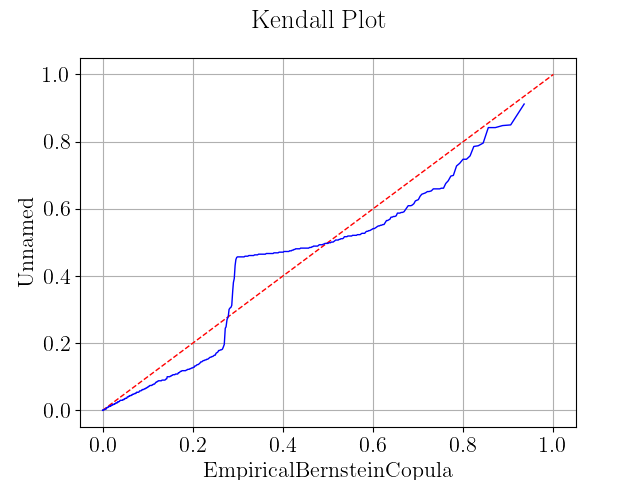

In [13]:
# Empirical Bernstein copula goodness of fit
subset_idx = 1
fitted_copula = bancs.conditional_distributions[subset_idx].getCopula()
sample = bancs.df[(bancs.df["Failed"]==1) & (bancs.df["Subset"]==subset_idx-1)][['X0', 'X1']].values
#sample.setName('Subset sample $\mathbf{X}_N^{2} | g(\mathbf{X}_N^{2}) < \hat{q_N^{2}}$')
kendallPlot = ot.VisualTest.DrawKendallPlot(sample, fitted_copula)
kendallPlot